# Diabetes Prediction 

## Classification Model

By Jenna Le Noble

### Introduction

The diabetes.csv dataset is from the National Institute of Diabetes and Digestive and Kidney
Diseases. It includes data on female patients of the age of 21 years and older of Pima Indian heritage. The purpose of this project is to predict whether a patient has diabetes based on certain characteristics and health measurements. The following column variables are described below:

- `pregnancies`: the number of pregnancies the patient has experienced
- `glucose`: glucose level in blood (mg/dL)
- `blood_pressure`: blood pressure measurement (mmHg)
- `skin_thickness`: thickness of skin (μm)
- `insulin`: insulin level in blood (pmol/L)
- `bmi`: body mass index (kg/m$^2$)
- `diabetes_pedrigee`: diabetes percentage
- `age`: age  of patient (years)
- `diabetes`: does the patient have diabetes (yes or no)

### Exploratory Data Analysis

In [1]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [2]:
diabetes_data <- read_csv("https://raw.githubusercontent.com/jennalenoble/diabetes_classification/main/diabetes.csv")

colnames(diabetes_data) <- c("pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "bmi", "diabetes_pedrigree", "age", "diabetes")

diabetes_data <- mutate(diabetes_data, diabetes = as.factor(diabetes))

levels(diabetes_data$diabetes) <- c("no", "yes")

diabetes_data <- filter(diabetes_data, insulin != 0, glucose != 0) 
diabetes_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedrigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,no
0,137,40,35,168,43.1,2.288,33,yes
3,78,50,32,88,31.0,0.248,26,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,no
10,101,76,48,180,32.9,0.171,63,no
5,121,72,23,112,26.2,0.245,30,no


#### Table 1: Diabetes Data

This table demonstrates the various factors and measurements taken from each patient. The last column states whether the patient has diabetes or not.

We can explore different factors by plotting the different variables on scatter plots.

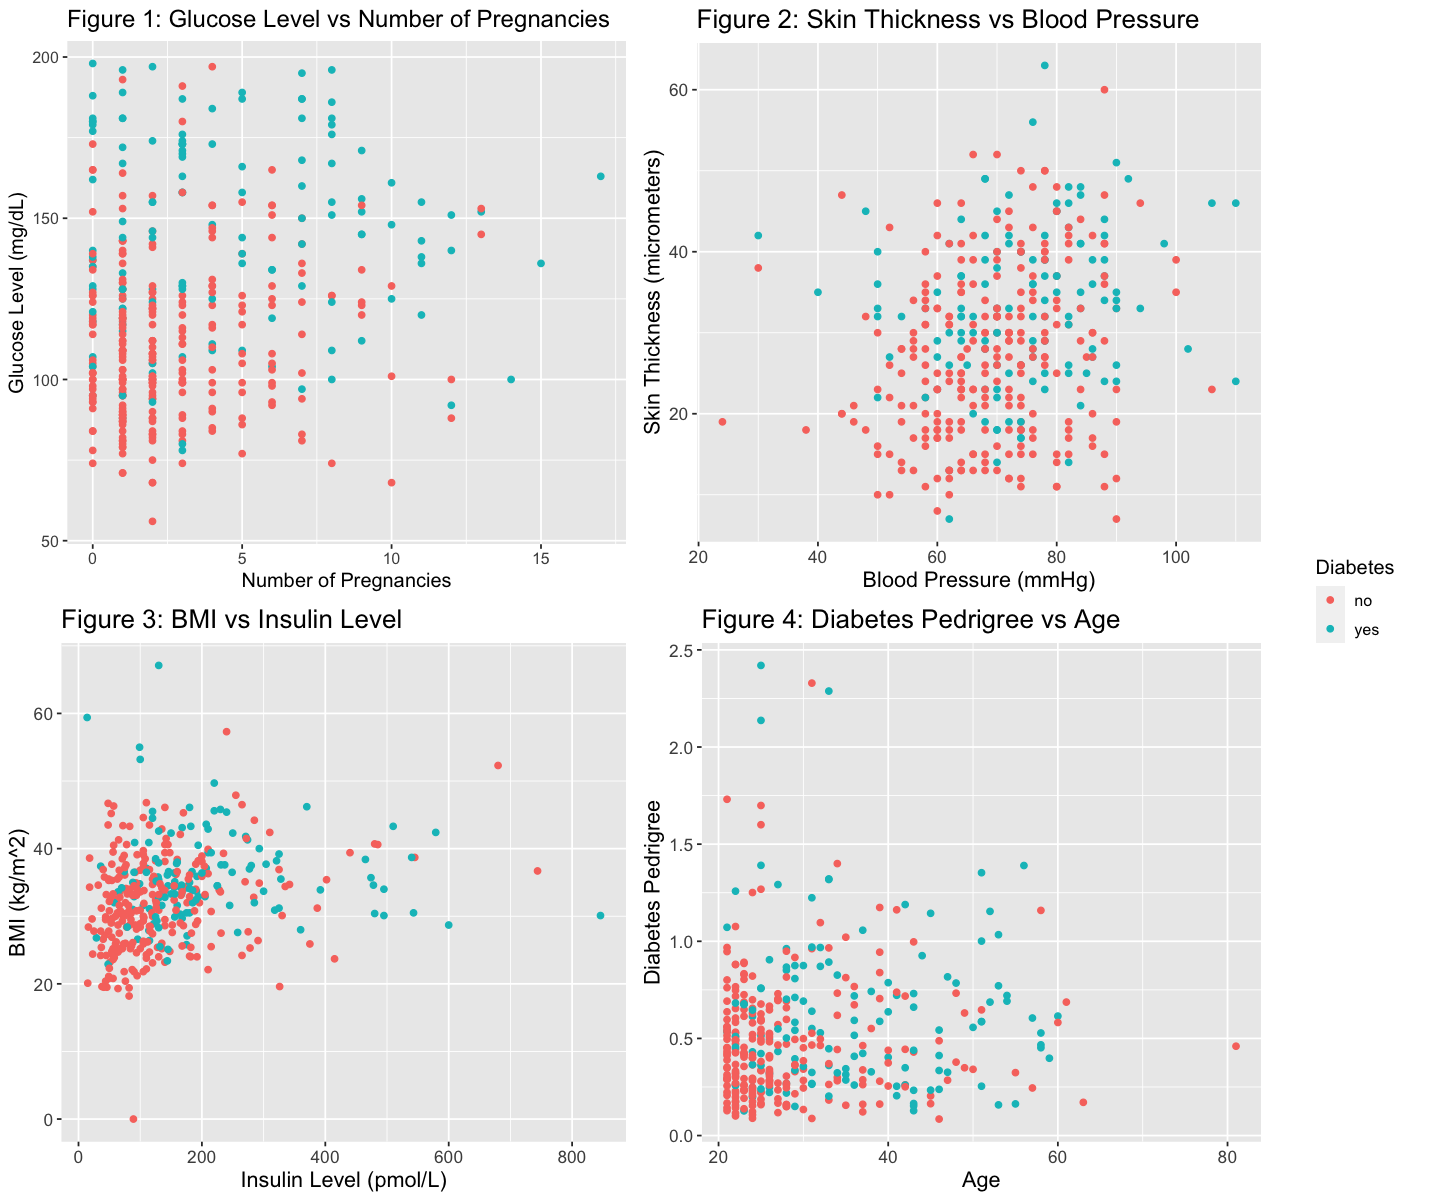

In [15]:
options(repr.plot.width=12, repr.plot.height=10)
library(cowplot)

plot1 <- diabetes_data %>%
    ggplot(aes(x = pregnancies, y = glucose)) +
        geom_point(aes(color = diabetes)) +
        labs(x = "Number of Pregnancies", y = "Glucose Level (mg/dL)", colour = "Diabetes") +
        ggtitle("Figure 1: Glucose Level vs Number of Pregnancies") +
        theme(text = element_text(size = 12))

plot2 <- diabetes_data %>%
    ggplot(aes(x = blood_pressure, y = skin_thickness)) +
        geom_point(aes(color = diabetes)) +
        labs(x = "Blood Pressure (mmHg)", y = "Skin Thickness (micrometers)", colour = "Diabetes") +
        ggtitle("Figure 2: Skin Thickness vs Blood Pressure") +
        theme(text = element_text(size = 13))

plot3 <- diabetes_data %>%
        ggplot(aes(x = insulin, y = bmi)) +
            geom_point(aes(color = diabetes)) +
            labs(x = "Insulin Level (pmol/L)", y = "BMI (kg/m^2)", colour = "Diabetes") +
            ggtitle("Figure 3: BMI vs Insulin Level") +
            theme(text = element_text(size = 13))

plot4 <- diabetes_data %>%
        ggplot(aes(x = age, y = diabetes_pedrigree)) +
            geom_point(aes(color = diabetes)) +
            labs(x = "Age", y = "Diabetes Pedrigree", colour = "Diabetes") +
            ggtitle("Figure 4: Diabetes Pedrigree vs Age") +
            theme(text = element_text(size = 13))

pgrid <- plot_grid(
  plot1 + theme(legend.position="none"),
  plot2 + theme(legend.position="none"),
  plot3 + theme(legend.position="none"),
  plot4 + theme(legend.position="none"),
  ncol = 2)

legend <- get_legend(plot1)
 
plot_grid(pgrid, legend, rel_widths = c(3, .4))

The figures above demonstrate different data measurements and whether they are from patients with diabetes (blue points) or without diabetes (red points). We will use each of these variables in a classification model using K nearest neighbours, in order to predict whether a patient has diabetes or not.

### Methods & Results

First, we split our data into training and testing sets in order to train the model with the training data (75%), and test the model with the testing data (25%):

In [4]:
set.seed(2000)
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = diabetes)  
diabetes_train <- training(diabetes_split)   
diabetes_test <- testing(diabetes_split)

Next, we create a spec and recipe for the model, while scaling and centering the predictor values so that each predictor evenly affects the outcome. We will also perform 10-fold cross validation so that we can get a better estimate of accuracy, which will lead to a better choice for the number of neighbors K. Then we will tune our model to determine the best K, and will use the K value with the highest accuracy to fit our model to the training data. Finally, we will test our model with the testing data to see how it performs with data it has not seen before.

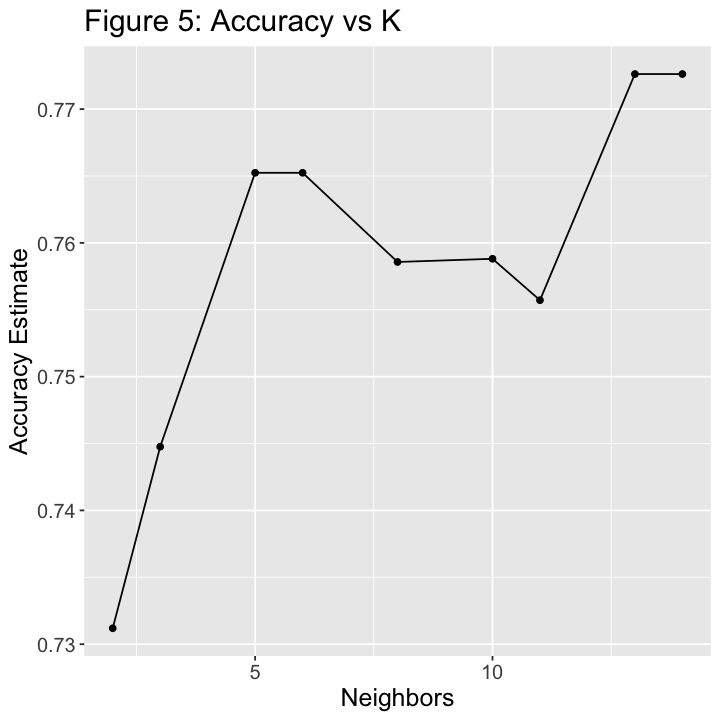

In [5]:
options(repr.plot.width=6, repr.plot.height=6)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

diabetes_data_recipe <- recipe(diabetes ~ ., data = diabetes_data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

diabetes_vfold <- vfold_cv(diabetes_train, v = 10, strata = diabetes)

diabetes_fit <- workflow() |>
       add_recipe(diabetes_data_recipe) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = diabetes_vfold)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_results <- workflow() |>
       add_recipe(diabetes_data_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = diabetes_vfold, grid = 10) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Figure 5: Accuracy vs K") +
        theme(text = element_text(size = 15))
accuracy_versus_k

From the plot, we can see that using K = 14 neighbours results in the highest accuracy. Thus, we will use 14 neighbours for our model.

In [6]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

diabetes_fit <- workflow() |>
    add_recipe(diabetes_data_recipe) |>
    add_model(knn_spec) |>
    fit(data = diabetes_train)

diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)

diabetes_metrics <- diabetes_predictions |>
    metrics(truth = diabetes, estimate = .pred_class)

diabetes_conf_mat <- diabetes_predictions |>
    conf_mat(truth = diabetes, estimate = .pred_class)

diabetes_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7777778
kap,binary,0.4406780


#### Table 2: Accuracy of Model

This table tells us that the model is 77.8% accurate.

In [7]:
diabetes_conf_mat

          Truth
Prediction no yes
       no  62  18
       yes  4  15

#### Table 3: Prediction Matrix

This table tells us that when tested on the testing data, the model correctly predicted that a patient did not have diabetes 62 times, and incorrectly predicted that a patient did not have diabetes 18 times. Additionally, the model correctly predicted that a patient had diabetes 15 times, and incorrectly predicted that a patient had diabetes 4 times.

### Discussion